# Analysing predicted poses for EPM

This notebook analyses predicted poses for a single mouse performing an elevated plus maze (EPM) task.

It first imports predicted poses from either [SLEAP](https://sleap.ai) or [DeepLabCut](https://www.mackenziemathislab.org/deeplabcut) using [movement](https://movement.neuroinformatics.dev/).

Subsequently, the following operations are performed on predicted poses:
- plot trajectories and confidence scores
- filter tracks to exclude low-confidence points and interpolate over missing points
- compute of time-spent in different parts of the maze

## A. Setup
### A1. Create a conda environment and install required packages

In a terminal, clone the repository and go to the `notebooks` directory:
```bash
git clone https://github.com/neuroinformatics-unit/course-behavioural-analysis.git
cd course-behavioural-analysis/notebooks
```

Create a new conda environment and install required packages:
```bash
conda create -n epm-analysis -c conda-forge python=3.11 pip pytables
conda activate epm-analysis
pip install -r EPM_analysis_requirements.txt
```

Once all requirements are installed, you can open this notebook and select the `epm-analysis` kernel.

### A2. Import required packages

In [1]:
from pathlib import Path

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point

from movement.io import load_poses
from movement.filtering import filter_by_confidence, median_filter

### A3. Specify paths to data

You should modify `DATA_DIR` to point to the directory where you downloaded the `mouse-EPM` folder containing the sample data.

The `derivatives` subfolder contains predictions from both SLEAP and DeepLabCut.
```bash
.
├── derivatives
│   └── behav
│       ├── software-DLC_predictions
│       └── software-SLEAP_project
│           └── predictions
│
└── rawdata
    ├── sub-01_ses-01_task-EPM_time-165049_video.mp4
    └── sub-02_ses-01_task-EPM_time-185651_video.mp4
```

- The SLEAP predictions were generated by Niko Sirmpilatze, based on only a few training examples.
- The DeepLabCut predictions were generated by Loukia Katsouri and should be of higher quality than the SLEAP predictions.

In [2]:
DATA_DIR = Path.home() / "Data" / "behav-analysis-course" / "mouse-EPM"

derivatives_dir = DATA_DIR / "derivatives"

# SLEAP predictions
sleap_predictions_dir = derivatives_dir / "software-SLEAP_project" / "predictions"
video1_sleap_preds_file = sleap_predictions_dir / "video-1.predictions.analysis.h5"
video2_sleap_preds_file = sleap_predictions_dir / "video-2.predictions.analysis.h5"

# DeepLabCut predictions
dlc_predictions_dir = derivatives_dir / "software-DLC_predictions"
video1_dlc_preds_file = dlc_predictions_dir / "sub-01_ses-01_task-EPM_time-165049_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000_filtered.h5"
video2_dlc_preds_file = dlc_predictions_dir / "sub-02_ses-01_task-EPM_time-185651_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000_filtered.h5"

# Frames (used as background for plotting)
video1_frame_file = dlc_predictions_dir / "sub-01_ses-01_task-EPM_time-170049_frame.png"
video2_frame_file = dlc_predictions_dir / "sub-02_ses-01_task-EPM_time-190651_frame.png"

Check that the above paths are correct by running the following cell:

In [3]:
for folder in [derivatives_dir, sleap_predictions_dir, dlc_predictions_dir]:
    assert folder.is_dir()

for file in [
    video1_sleap_preds_file,
    video2_sleap_preds_file,
    video1_dlc_preds_file,
    video2_dlc_preds_file,
    video1_frame_file,
    video2_frame_file,
]:
    assert file.is_file()

## B. Load and explore predictions
### B1. Load predicted poses with `movement`
The pose tracks and the associated point-wise confidence scores are imported using [`movement`]((https://movement.neuroinformatics.dev/)) and represented as [xarray.Dataset](https://movement.neuroinformatics.dev/getting_started.html#dataset-structure) objects.

In [32]:
ds_sleap_video1 = load_poses.from_file(
    video1_sleap_preds_file,
    source_software="SLEAP",
    fps=30
)
ds_sleap_video1

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 18485, individuals: 1, keypoints: 6, space: 2)
Coordinates:
  * time         (time) float64 148kB 0.0 0.03333 0.06667 ... 616.1 616.1 616.1
  * individuals  (individuals) <U12 48B 'individual_0'
  * keypoints    (keypoints) <U9 216B 'snout' 'left_ear' ... 'tail_end'
  * space        (space) <U1 8B 'x' 'y'
Data variables:
    position     (time, individuals, keypoints, space) float32 887kB nan ... ...
    confidence   (time, individuals, keypoints) float32 444kB nan nan ... 0.7607
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      /Users/nsirmpilatze/Data/behav-analysis-course/mouse-EP...
    ds_type:          poses

**Exercise 1:**

- Load the DeepLabCut predictions for video1 (`sub-01`) into a `ds_dlc_video1` variable.
- Do you notice any differences between the SLEAP and DeepLabCut predictions?

**Hint:** consult the [Loading pose tracks](https://movement.neuroinformatics.dev/getting_started/input_output.html#loading-pose-tracks) section of the `movement` documentation.

In [5]:
# Write your code here

Check that your solution is correct by running the following cell:

In [63]:
assert isinstance(ds_dlc_video1, xr.Dataset), "ds_dlc_video1 should exist and be an xarray Dataset"
assert ds_dlc_video1.source_software == "DeepLabCut", "ds_dlc_video1 should have source_software='DeepLabCut'"

### B2. Select subsets of the data
Below we get the "position" data variable for 3 keypoints: "snout", "centre", "tail_base"

In [6]:
position_sleap_3kps = ds_sleap_video1.position.sel(keypoints=["snout", "centre", "tail_base"])
position_sleap_3kps

<xarray.DataArray 'position' (time: 18485, individuals: 1, keypoints: 3,
                              space: 2)> Size: 444kB
nan nan nan nan nan nan nan nan ... 384.0 684.7 504.8 667.8 440.0 636.8 384.1
Coordinates:
  * time         (time) float64 148kB 0.0 0.03333 0.06667 ... 616.1 616.1 616.1
  * individuals  (individuals) <U12 48B 'individual_0'
  * keypoints    (keypoints) <U9 108B 'snout' 'centre' 'tail_base'
  * space        (space) <U1 8B 'x' 'y'

**Exercise 2:**

- Work with the `ds_dlc_video1` dataset you created in **Exercise 1**.
- Get the `confidence` data values for the `snout` keypoint, between time 2 and 4 minutes (inclusive), and store them in a variable called `snout_confidence`.

**Hint:** Consult the [Working with movement datasets](https://movement.neuroinformatics.dev/getting_started/movement_dataset.html#working-with-movement-datasets) section of the `movement` documentation.

In [13]:
# Write your code here


Check if your solution is correct by running the following cell:

In [66]:
assert isinstance(snout_confidence, xr.DataArray), "snout_confidence should exist and be an xarray DataArray"
assert snout_confidence.dims == ("time", "individuals"), "snout_confidence should have dims=('time', 'individuals')"
assert snout_confidence.shape[0] == 2 * 60 * 30 + 1, "snout_confidence should 3601 time points (2 minutes at 30 fps + 1)"

### B3. Plot keypoint trajectories and confidence scores over time
First we can plot the trajectories of the 3 keypoints we selected above over time (from the SLEAP predictions).

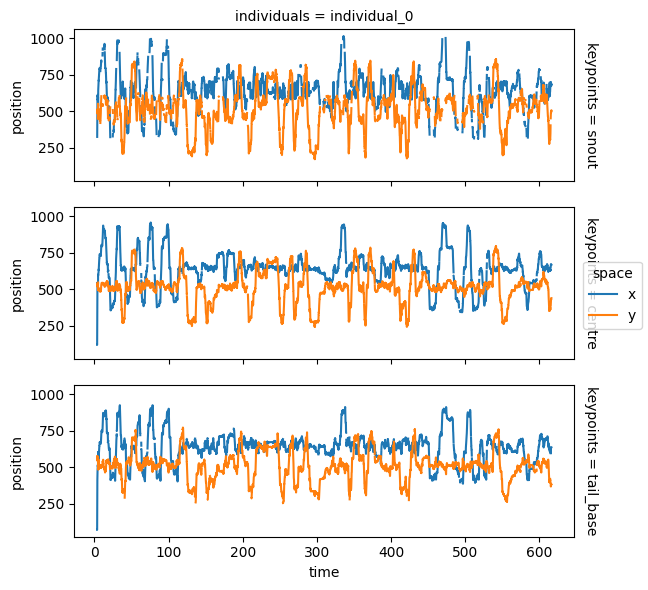

In [7]:
position_sleap_3kps.plot.line(
    x="time", row="keypoints", col="individuals", aspect=2.5, size=2
)

Now, we can plot the confidence scores for the same keypoints over time.

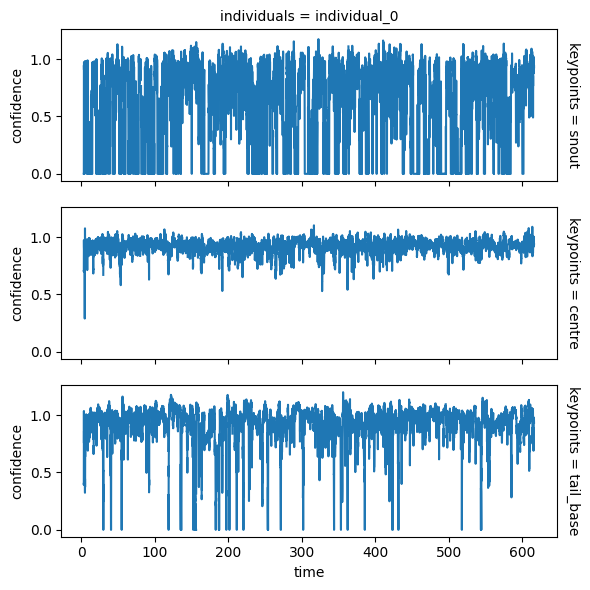

In [8]:
confidence_3kps = ds_sleap_video1.confidence.sel(keypoints=["snout", "centre", "tail_base"])
confidence_3kps.plot.line(
    x="time", row="keypoints", col="individuals", aspect=2.5, size=2,
)

**Exercise 3:**

- Work with the `ds_dlc_video1` dataset you created in **Exercise 1**.

- Get the `position` data values for the 3 keypoints `["snout", "centre", "tailbase"]` as `position_dlc_3kps`.

- Get the `confidence` data values for the 3 keypoints `["snout", "centre", "tailbase"]` as `confidence_dlc_3kps`.

- Plot the x,y positions and confidence scores for the 3 keypoints over time.

- What do you notice? How do they compare to the SLEAP pose tracks and confidence scores that we plotted above?

**Hint:** Consult the [Plotting](https://docs.xarray.dev/en/stable/user-guide/plotting.html) section of the `xarray` documentation.

In [50]:
# Write your code here to get and plot the x,y position for the 3 keypoints from the DLC dataset


In [ ]:
# Write your code here to get and plot the confidence scores for the 3 keypoints from the DLC dataset

Check if your solution is correct by running the following cell:

In [74]:
necessary_keypoints = ["snout", "centre", "tailbase"]
necessary_data_arrays = {"pose_tracks_dlc_3kps": position_dlc_3kps, "confidence_dlc_3kps": confidence_dlc_3kps}
for var_name, data_array in necessary_data_arrays.items():
    assert isinstance(data_array, xr.DataArray), f"{var_name} should exist and be an xarray DataArray"
    assert all(
        k in data_array.keypoints.values for k in necessary_keypoints
    ), f"{var_name} should have keypoints={necessary_keypoints}"


### B4. Plot keypoint trajectories over the video frame
First, we load the video frame.

**Note:**  the relative position of the setup and the camera doesn't change between the two videos, so one frame can be used for both.

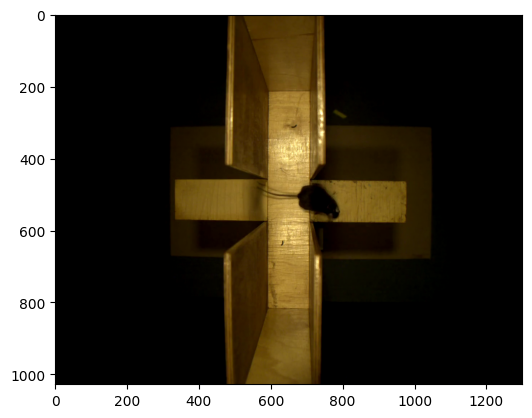

In [9]:
frame_img = plt.imread(video1_frame_file)
plt.imshow(frame_img)

Then we define a function to plot selected pose tracks over the video frame.

In [10]:
def plot_trajectory(
        ds: xr.Dataset,
        individual: str,
        keypoint: str,
        time_range: tuple = None,
        frame: np.ndarray = None,
):
    """Plot trajectory of a single keypoint for a given individual.
    Optionally, the trajectory can be restricted to a time range and a frame
    can be shown as background.
    
    Parameters
    ----------
    ds : xr.Dataset
        Dataset containing pose tracks.
    individual : str
        Name of the individual to plot.
    keypoint : str
        Name of the keypoint to plot.
    time_range : tuple, optional
        Start and end time of the trajectory to plot. If None, the entire
        trajectory will be plotted.
    frame : np.ndarray, optional
        Image to use as background. If None, the frame will not be shown.
    """
    
    fig, ax = plt.subplots(figsize=(7, 7))

    # Show the frame, if provided
    if frame is not None:
        ax.imshow(frame)

    # Select the appropriate data
    data = ds.position.sel(individuals=individual, keypoints=keypoint)
    if time_range is not None:
        data = data.sel(time=slice(*time_range))
        
    plt.scatter(
        data.sel(space="x"), data.sel(space="y"), s=1, c=data.time, cmap="plasma"
    )
    plt.title(f"Trajectory of {individual} {keypoint}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(label="time (s)", orientation="horizontal")

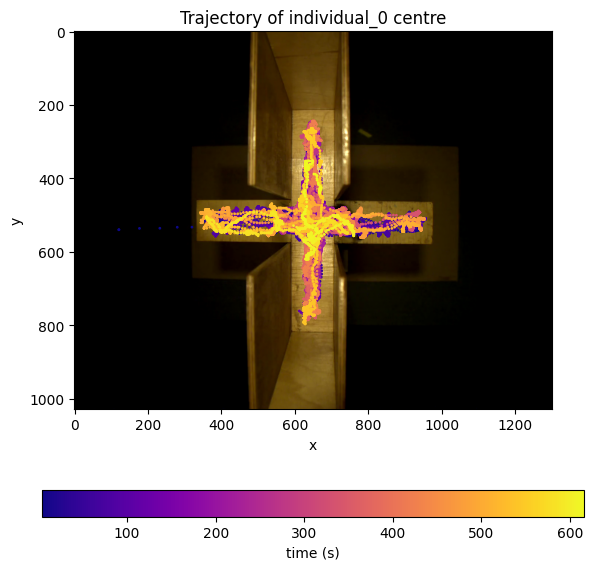

In [11]:
plot_trajectory(
    ds_sleap_video1,
    individual="individual_0",
    keypoint="centre",
    frame=frame_img,
)

**Exercise 4:**

- Work with the `ds_dlc_video1` dataset you created in **Exercise 1**.
- Use the `plot_trajectory()` function to plot the pose tracks for `individual_0`  and keypoint `snout` over the entire time range.
- Use the `plot_trajectory()` function again but restrict the time range to (1-10) minutes.
- What is different between the two plots? Why?
- Now plot the trajectory for the `tailbase` keypoint the time range to (1-10) minutes, what is the difference to the `snout` trajectory?

In [108]:
# snout trajectory plot for the entire time range


In [109]:
# snout trajectory plot for the time range 1-10 minutes


In [110]:
# tailbase trajectory plot for the time range 1-10 minutes


## C. Filter trajectories
### C1. Discard points with low confidence scores
We can filter out low-confidence points from the trajectories, by setting their values to `NaN`.

However, we should be careful with choosing a threshold for the confidence score, which may depend on the software used to generate the predictions.

First, let's plot the histograms of confidence scores to get an idea of how they are distributed.

In [12]:
def plot_confidence_hist(
        ds: xr.Dataset,
        individual: str,
        keypoints: list,
        threshold: float = None
):
    """Plot histogram of confidence scores across keypoints for a given individual.
    
    Parameters
    ----------
    ds : xr.Dataset
        Dataset containing confidence scores.
    individual : str
        Name of the individual to plot.
    keypoints : list
        List of keypoints to plot. if None, all keypoints will be plotted.
    threshold : float, optional
        If provided, a vertical line will be drawn at this confidence score.
    """

    if not keypoints:
        keypoints = ds.keypoints.values

    confidence = ds.confidence.sel(individuals=individual, keypoints=keypoints)
    n_keypoints = len(keypoints)

    fig, axes = plt.subplots(n_keypoints, 1, figsize=(7, 2 * n_keypoints + 1), sharex=True)

    for ax, kp in zip(axes, keypoints):
        ax.hist(confidence.sel(keypoints=kp), bins=100, density=True)
        ax.set_title(f"{individual} {kp}")
        ax.set_ylabel("density")
        if threshold is not None:
            ax.axvline(threshold, c="r")

    axes[-1].set_xlabel("confidence")

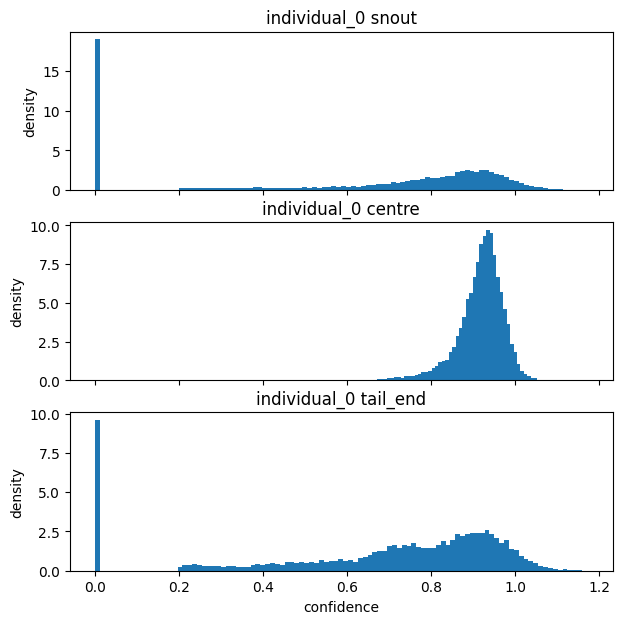

In [16]:
plot_confidence_hist(
    ds_sleap_video1,
    individual="individual_0",
    keypoints=["snout", "centre", "tail_end"],
)

As we can see, the confidence score distributions differ widely across keypoints, as some keypoints (e.g. `centre`) are easier to detect than others (e.g. `tail_end`).

For the following steps, we arbitrarily choose a threshold of 0.6, i.e. points with confidence scores below 0.6 will be excluded from the trajectories.

In [33]:
# Make a copy of the dataset to avoid modifying the original
ds_sleap_video1_thresh = ds_sleap_video1.copy()

# Set all values below the threshold to NaN
filtered_position = filter_by_confidence(
    ds_sleap_video1.position, ds_sleap_video1.confidence, threshold=0.6
)
ds_sleap_video1_thresh.update({"position": filtered_position})


Missing points (marked as NaN) in input
	Individual: individual_0
		snout: 4494/18485 (24.3%)
		left_ear: 513/18485 (2.8%)
		right_ear: 533/18485 (2.9%)
		centre: 490/18485 (2.7%)
		tail_base: 704/18485 (3.8%)
		tail_end: 2496/18485 (13.5%)

Missing points (marked as NaN) in output
	Individual: individual_0
		snout: 6866/18485 (37.1%)
		left_ear: 1017/18485 (5.5%)
		right_ear: 1497/18485 (8.1%)
		centre: 499/18485 (2.7%)
		tail_base: 1329/18485 (7.2%)
		tail_end: 5593/18485 (30.3%)


<xarray.Dataset> Size: 1MB
Dimensions:      (time: 18485, individuals: 1, keypoints: 6, space: 2)
Coordinates:
  * time         (time) float64 148kB 0.0 0.03333 0.06667 ... 616.1 616.1 616.1
  * individuals  (individuals) <U12 48B 'individual_0'
  * keypoints    (keypoints) <U9 216B 'snout' 'left_ear' ... 'tail_end'
  * space        (space) <U1 8B 'x' 'y'
Data variables:
    position     (time, individuals, keypoints, space) float32 887kB nan ... ...
    confidence   (time, individuals, keypoints) float32 444kB nan nan ... 0.7607
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      /Users/nsirmpilatze/Data/behav-analysis-course/mouse-EP...
    ds_type:          poses

As a sanity check, we can plot the confidence score histograms again for the thresholded dataset. Values below the threshold should be absent.

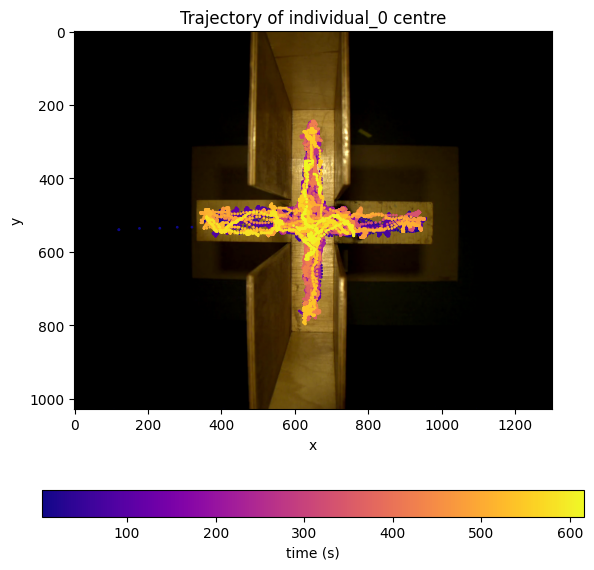

In [37]:
plot_trajectory(
    ds_sleap_video1_thresh,
    individual="individual_0",
    keypoint="centre",
    frame=frame_img,
)

### C2. Interpolate over missing points
Sometimes a keypoint may disappear for a few frames, e.g. if it's occluded by another object.

We can "fill in" the missing points by interpolating over short gaps. Interpolating over longer gaps may lead to inaccurate results, as the uncertainty about the position of the keypoint increases.

Below we will use "cubic" interpolation, but other methods are available (see [xarray.DataArray.interpolate_na](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interpolate_na.html)). We will set the maximum gap length to 1 second, but feel free to experiment with other values.
We can plot the trajectories again to see the effect of interpolation.

In [16]:
# interpolate over missing values (NaNs) for gaps of up to max_gap seconds
ds_sleap_video1_filtered = ds_sleap_video1_thresholded.interpolate_na(
    dim="time", method="cubic", max_gap=1
)

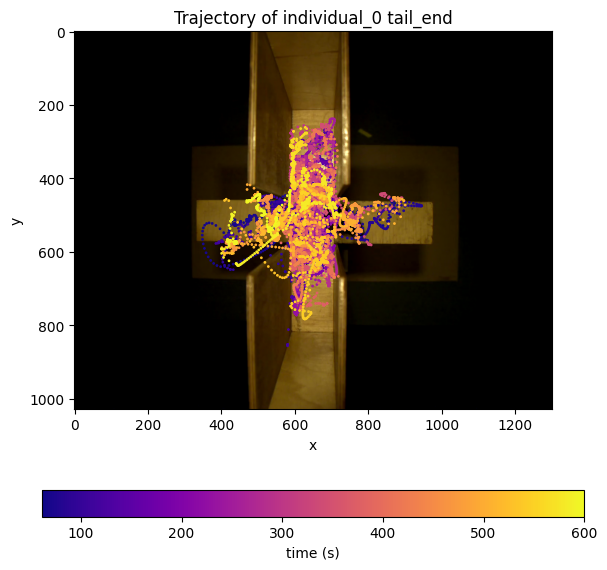

In [17]:
plot_trajectory(
    ds_sleap_video1_filtered,
    individual="individual_0",
    keypoint="tail_end",
    frame=frame_img,
    time_range=(1 * 60, 10 * 60),
)

**Exercise 5:**

- Repeat the above filtering and interpolation procedure for the `ds_dlc_video1` dataset you loaded in **Exercise 1**.
- Plot the confidence score histograms before and after filtering.
- Experiment with various thresholds, interpolation methods and gap lengths.
- Visualise the trajectories before and after filtering and interpolation.

In [223]:
# write your code here, feel free to add more cells as needed

## D. Compute time spent in different parts of the maze

### D1. Define regions of interest (ROIs)

First we will have to define the different parts of the maze and their coordinates as ROIs:

- `open_arm_left`
- `open_arm_right`
- `closed_arm_bottom`
- `closed_arm_top`
- `central_square`

The cell below provides the vertex coordinates for each ROI in the form of a dictionary. In practice, you would have to define these coordinates using tools such as [ImageJ](https://imagej.net/ij/) or [Napari](https://napari.org/) and then import them into Python. ROI definition functionality is also planned for a [future version of `movement`](https://movement.neuroinformatics.dev/community/roadmap.html).

In [18]:
# Each ROI is represented as a list of (x, y) coordinates in pixels
rois = {
    "open_arm_left": [
        [323, 452], [412, 447], [511, 449], [591, 458], [591, 575],
        [522, 588], [416, 586], [324, 581], [322, 516], [323, 452],
    ],
    "open_arm_right": [
        [707, 460], [793, 449], [893, 452], [983, 453], [986, 515],
        [984, 587], [899, 590], [791, 589], [705, 577], [707, 460],
    ],
    "closed_arm_bottom": [
        [592, 574], [706, 576], [714, 643], [711, 740], [711, 829],
        [642, 828], [583, 827], [579, 749], [580, 659], [592, 574],
    ],
    "closed_arm_top": [
        [587, 198], [651, 196], [716, 201], [717, 291], [721, 383],
        [707, 458], [590, 457], [579, 381], [580, 278], [587, 198],
    ],
    "central_square": [
        [591, 458], [707, 459], [707, 576], [590, 575], [591, 458],
    ],
}

First, let's plot the ROIs on top of the video frame, to make sure we've got the coordinates right.

In [19]:
def plot_rois_on_frame(frame: np.ndarray, rois: dict):
    """Plot ROI coordinates on top of a frame.
    
    Parameters
    ----------
    frame : np.ndarray
        Frame to plot.
    roi_coords : dict
        dictionary mapping ROI names to 2D coordinates (x, y) in pixels.
    """
    
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(frame)
    for roi_name, roi_coords in rois.items():
        ax.plot(*np.array(roi_coords).T, lw=2, label=roi_name)
    ax.axis("off")
    ax.legend()

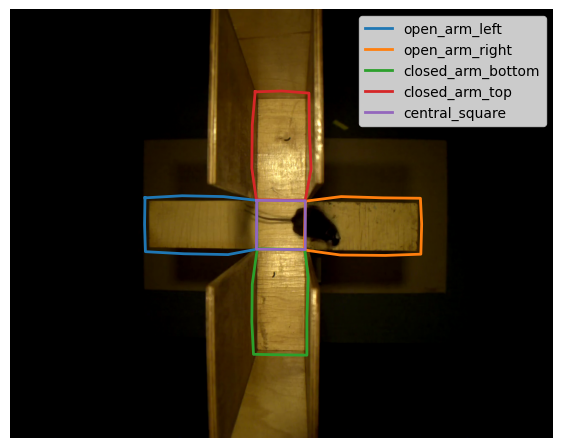

In [20]:
plot_rois_on_frame(frame_img, rois)

### D2. Compute time spent in each ROI

Firs we define some helper functions which determine if a set of points is inside a polygon,
either for a single frame or frame-by-frame.

In [21]:
def polygon_contains_all_points(
    roi_polygon: Polygon,
    points: np.ndarray,
) -> bool:
    """Return true if all points are within a polygon.
    
    Parameters
    ----------
    roi_polygon : shapely.geometry.Polygon
        Polygon to check.
    points : np.ndarray
        2D array of (x, y) points to check.

    Returns
    -------
    bool
        True if all points are within the polygon.
    """
    return np.all([roi_polygon.contains(Point(point)) for point in points])


def polygon_contains_all_points_framewise(
    roi_polygon: Polygon,
    point_timeseries: np.ndarray,
) -> np.ndarray:
    """
    Return a boolean mask indicating whether all points are within the polygon
    for each frame.

    Parameters
    ----------
    roi_polygon : shapely.geometry.Polygon
        Polygon to check.
    point_timeseries : np.ndarray
        3D array of (n_frames, x, y) points to check.
    
    Returns
    -------
    np.ndarray
        Boolean mask indicating whether all points are within the polygon
        for each frame.
    """
    return np.array(
            [polygon_contains_all_points(roi_polygon, fr) for fr in point_timeseries]
        )


# sanity check
test_polygon = Polygon([[0, 0], [1, 0], [1, 1], [0, 1]])  # unit square
test_point_timeseries = np.array([
    [[0.5, 0.5], [0.6, 0.3], [0.2, 0.7]],  # within the square
    [[1.5, 1.5], [0.6, 0.3], [0.2, 0.7]],  # outside the square
])
test_array = polygon_contains_all_points_framewise(test_polygon, test_point_timeseries)
assert np.all(test_array == np.array([True, False]))

Now we can compute which ROI was occupied at each frame, and derive the relative time spent in open vs closed arms.

In [22]:
def open_to_closed_arms_ratio(
    ds: xr.Dataset,
    individual: str,
    needed_keypoints: list,
    rois: dict,
) -> float:
    """
    Calculate the ratio of time spent in open arms vs closed arms.

    Parameters
    ----------
    ds : xr.Dataset
        Dataset containing pose tracks
    individual : str
        Name of the individual
    needed_keypoints : list
        List of keypoints that must be within the ROI
    rois : dict
        Dictionary mapping ROI names to 2D coordinates (x, y) in pixels.

    Returns
    -------
    float
        Ratio of time spent in open arms vs closed arms.
    """

    # Convert ROI coordinates to Shapely polygons
    roi_polygons = {roi_name: Polygon(roi_coords) for roi_name, roi_coords in rois.items()}

    # Select the appropriate data
    data = ds.pose_tracks.sel(individuals=individual, keypoints=needed_keypoints).values

    # Calculate the boolean mask for each ROI (True if all needed keypoints are within the ROI)
    roi_masks = {
        roi_name: polygon_contains_all_points_framewise(roi_polygon, data)
        for roi_name, roi_polygon in roi_polygons.items()
    }

    # Calculate the ratio of frames spent in open vs closed arms
    num_frames_in_open = (roi_masks["open_arm_left"] | roi_masks["open_arm_right"]).sum()
    num_frames_in_closed = (roi_masks["closed_arm_top"] | roi_masks["closed_arm_bottom"]).sum()

    return num_frames_in_open / num_frames_in_closed


In [23]:
result_sleap_video1 = open_to_closed_arms_ratio(
    ds_sleap_video1_filtered.sel(time=slice(1 * 60, 10 * 60)),
    individual="individual_0",
    needed_keypoints=["centre"],
    rois=rois,
)

print("Open to closed arms ratio:", result_sleap_video1)

Open to closed arms ratio: 1.0598218786758529


## E. Put it all together

Combine the above steps into a single function that takes as input an xarray dataset containing predicted poses and outputs the ratio of time spent in open vs closed arms.

Optionally, you can also plot a keypoint trajectory over the video frame.

In [24]:
def analyse_video_predictions(
        ds: xr.Dataset,
        individual: str,
        needed_keypoints: list,
        time_range: tuple,
        rois: dict,
        confidence_threshold: float = None,
        interp_max_gap: float = 1,
        plot: bool = False,
        plot_keypoint: str = "centre",
        plot_frame: np.ndarray = None,
) -> float:

    # restrict to time range, if provided
    if time_range:
        ds_to_analyse = ds.sel(time=slice(*time_range))
    
    # filter by confidence threshold, if provided
    if confidence_threshold:
        ds_to_analyse = ds_to_analyse.where(ds_to_analyse.confidence > confidence_threshold)

    # interpolate over missing values (NaNs) for gaps of up to max_gap seconds
    ds_filtered = ds_to_analyse.interpolate_na(dim="time", method="cubic", max_gap=interp_max_gap)

    if plot:
        plot_trajectory(
            ds_filtered,
            individual=individual,
            keypoint=plot_keypoint,
            frame=plot_frame,
            time_range=time_range,
        )

    # calculate the ratio of time spent in open vs closed arms
    return open_to_closed_arms_ratio(ds_filtered, individual, needed_keypoints, rois)


For example this is how we can apply the function to the second video's SLEAP predictions:

Open to closed arms ratio: 1.6409021794221996


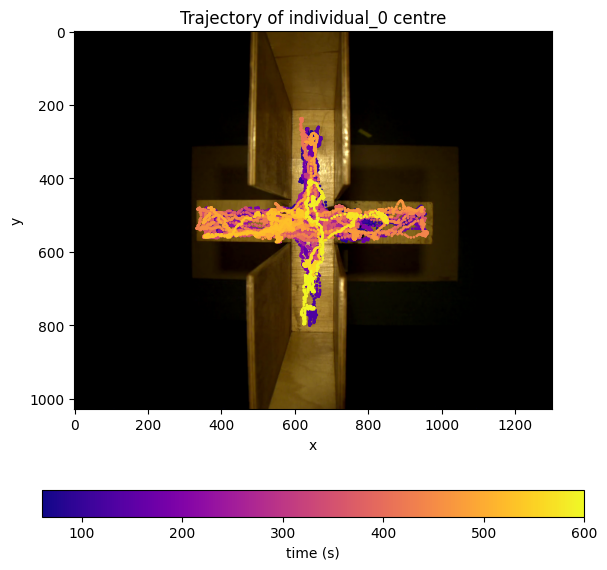

In [25]:
ds_sleap_video2 = load_poses.from_sleap_file(video2_sleap_preds_file, fps=30)

result_sleap_video2 = analyse_video_predictions(
    ds_sleap_video2,
    individual="individual_0",
    needed_keypoints=["centre", "tail_base"],
    time_range=(1 * 60, 10 * 60),
    rois=rois,
    confidence_threshold=0.6,
    interp_max_gap=1,
    plot=True,
    plot_keypoint="centre",
    plot_frame=plt.imread(video1_frame_file),
)

print("Open to closed arms ratio:", result_sleap_video2)

**Exercise 6:**

- Use the `analyse_video_predictions()` function to compute the time spent in each ROI for each video and each software package.
- Which mouse (`sub-01` or `sub-02`) was more anxious? Do SLEAP and DeepLabCut agree?


In [409]:
# Write your code here, feel free to add more cells as needed